### Power and coherence are dynamic

In [1]:
import sys

sys.path.insert(1, "/home/vinicius/storage1/projects/GrayData-Analysis")

In [2]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import xarray as xr
from frites.stats import confidence_interval
from frites.utils import parallel_func
from mne.stats import fdr_correction
from PIL import Image
from scipy.signal import fftconvolve
from tqdm import tqdm
from utils import *

from config import get_dates, return_delay_split
from GDa.flatmap.flatmap import flatmap
from GDa.graphics import plot
from GDa.loader import loader

##### Setting configurations

In [3]:
_ROOT = os.path.expanduser("~/funcog/gda/")

In [4]:
metric = "coh"
monkey = "lucy"
ds = 1

In [5]:
early_cue, early_delay = return_delay_split(monkey, delay_type=ds)

In [6]:
sessions = get_dates(monkey)

In [7]:
stages = [[-0.4, 0], [0, 0.4], [0.5, 0.9], [0.9, 1.3], [1.1, 1.5]]
stage_labels = ["P", "S", "D1", "D2", "Dm"]

##### Auxiliar functions

In [8]:
import numba


def xr_w_score(data):
    return (data - data.mean("times")) / data.std("times")


@numba.njit
def _histogram(x, bins):
    return np.histogram(x, bins=np.linspace(-3, 3, 20))[0]


def signal_entropy(power):

    bins = np.linspace(-3, 3, 20)
    nbins = len(bins)

    counts = np.apply_along_axis(_histogram, -1, power, bins=bins)

    pk = counts / counts.sum(-1)[..., np.newaxis]

    H = stats.entropy(pk, qk=None, base=None, axis=-1) / np.log(nbins)
    H = xr.DataArray(
        H,
        dims=("roi", "freqs", "trials"),
        coords=(power.roi, power.freqs, power.trials),
    )

    return H

In [9]:
def compute_time_series_cv(data, nbins=10):
    """
    Compute the coefficient of variation (CV) of a time series.

    The CV is defined as the standard deviation divided by the mean of the time series. This function also computes a confidence interval for the CV at a specified level.

    Parameters
    ----------
    data : xarray.DataArray
        The time series data. It should have dimensions 'roi', 'trials', and 'times'.

    Returns
    -------
    cv : xarray.DataArray
        The coefficient of variation of the time series data. It has dimensions 'roi', 'trials', and 'times'.
    """
    cv = signal_entropy(data)  # data.std("times") / data.mean("times")
    return confidence_interval(cv, cis=95, axis=2, n_boots=1000, verbose=False)

In [10]:
data_loader = loader(_ROOT=_ROOT)

In [11]:
colors = dict(
    zip(
        [
            "motor",
            "parietal",
            "prefrontal",
            "somatosensory",
            "temporal",
            "visual",
            "auditory",
        ],
        ["r", "aqua", "b", "m", "goldenrod", "green", "brown"],
    )
)

#### Figure 1

In [12]:
kw_loader = dict(
    session="141024", aligned_at="cue", channel_numbers=True, monkey=monkey
)

In [13]:
power_task = data_loader.load_power(**kw_loader, trial_type=1, behavioral_response=1)

In [14]:
def plot_circles(ax):
    """
    Plot task scheme.
    """

    png = plt.imread("figures/task.png")
    plt.sca(ax)
    im = plt.imshow(png, interpolation="none")
    plt.axis("off")


def plot_brain_areas(ax):

    import matplotlib as mpl
    import matplotlib.patches as mpatches

    areas_dict = get_areas()

    area_no = dict(
        motor=0,
        parietal=1,
        prefrontal=2,
        somatosensory=3,
        temporal=4,
        visual=5,
        auditory=6,
    )

    areas = np.asarray([area for area in areas_dict.keys()])
    values = np.asarray([area_no[region] for region in areas_dict.values()])
    color = [colors[region] for region in areas_dict.values()]

    fmap = flatmap(values, areas)

    fmap.plot(
        ax, ax_colorbar=None, cbar_title=None, alpha=0.4, colormap=None, colors=color
    )


def plot_power(ax, roi):
    plt.sca(ax)
    power = power_task.sel(times=slice(-0.5, 0)).interp(
        freqs=np.linspace(3, 75, 20), method="linear"
    )
    power_st = power.sel(roi=roi).mean("times")
    power_mean = power.sel(roi=roi).mean(("times", "trials"))

    power_st.plot(x="freqs", hue="trials", color="b", lw=0.05)
    power_mean.plot(x="freqs", hue="trials", color="k")
    ax.get_legend().remove()
    [ax.spines[key].set_visible(False) for key in ["top", "right"]]


def plot_ts_power(ax, roi, showfreqs=False, showscale=False, showepochs=False):
    plt.sca(ax)

    import matplotlib as mpl

    cmap = mpl.cm.get_cmap("viridis", 10)
    color_list = [mpl.colors.rgb2hex(cmap(i)[:3]) for i in range(cmap.N)]

    power = power_task.sel(roi=roi, trials=100)
    power = (power - power.mean("times")) / power.std("times")

    freqs = power.freqs.data.astype(int)

    for i in range(10):
        (power[i] + 3 * i).plot(x="times", hue="trials", color=color_list[i], lw=0.5)
        if showfreqs:
            plt.text(2.05, 2.9 * i, f"{freqs[i]} Hz", rotation=30)
        if showscale:
            if i == 9:
                plt.hlines(-0.9, -0.5, 0, color="k")
                plt.vlines(-0.5, -0.9, -0.9 + 3, color="k", lw=3)
                plt.text(-0.5, -2.5, "500 ms", fontsize=8)
                plt.text(-0.65, 0, r"3$\sigma$", rotation=90, fontsize=8)
    plt.xlim([-0.5, 2])

    plt.vlines(0, -0.9, 30, color="k", lw=1)
    plt.vlines(0.5, -0.9, 30, color="k", lw=1)
    plt.vlines(1.5, -0.9, 30, color="k", lw=1)
    if showepochs:

        plt.hlines(31, -0.4, 0, color="k", lw=1)
        plt.hlines(31, 0, 0.4, color="g", lw=1)
        plt.hlines(31, 0.5, 0.9, color="b", lw=1)
        plt.hlines(31, 0.9, 1.3, color="r", lw=1)
        plt.hlines(30, 1.1, 1.5, color="purple", lw=1)

        plt.text(-0.2, 31.5, "P", fontsize=8)
        plt.text(0.15, 31.5, "S", fontsize=8)
        plt.text(0.67, 31.5, "D1", fontsize=8)
        plt.text(1.04, 31.5, "D2", fontsize=8)
        plt.text(1.25, 29.1, "Dm", fontsize=8)

    [ax.spines[key].set_visible(False) for key in ["top", "right", "left"]]

<ipython-input-14-4a0baed4dbcd>:59: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap("viridis", 10)
<ipython-input-14-4a0baed4dbcd>:59: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap("viridis", 10)


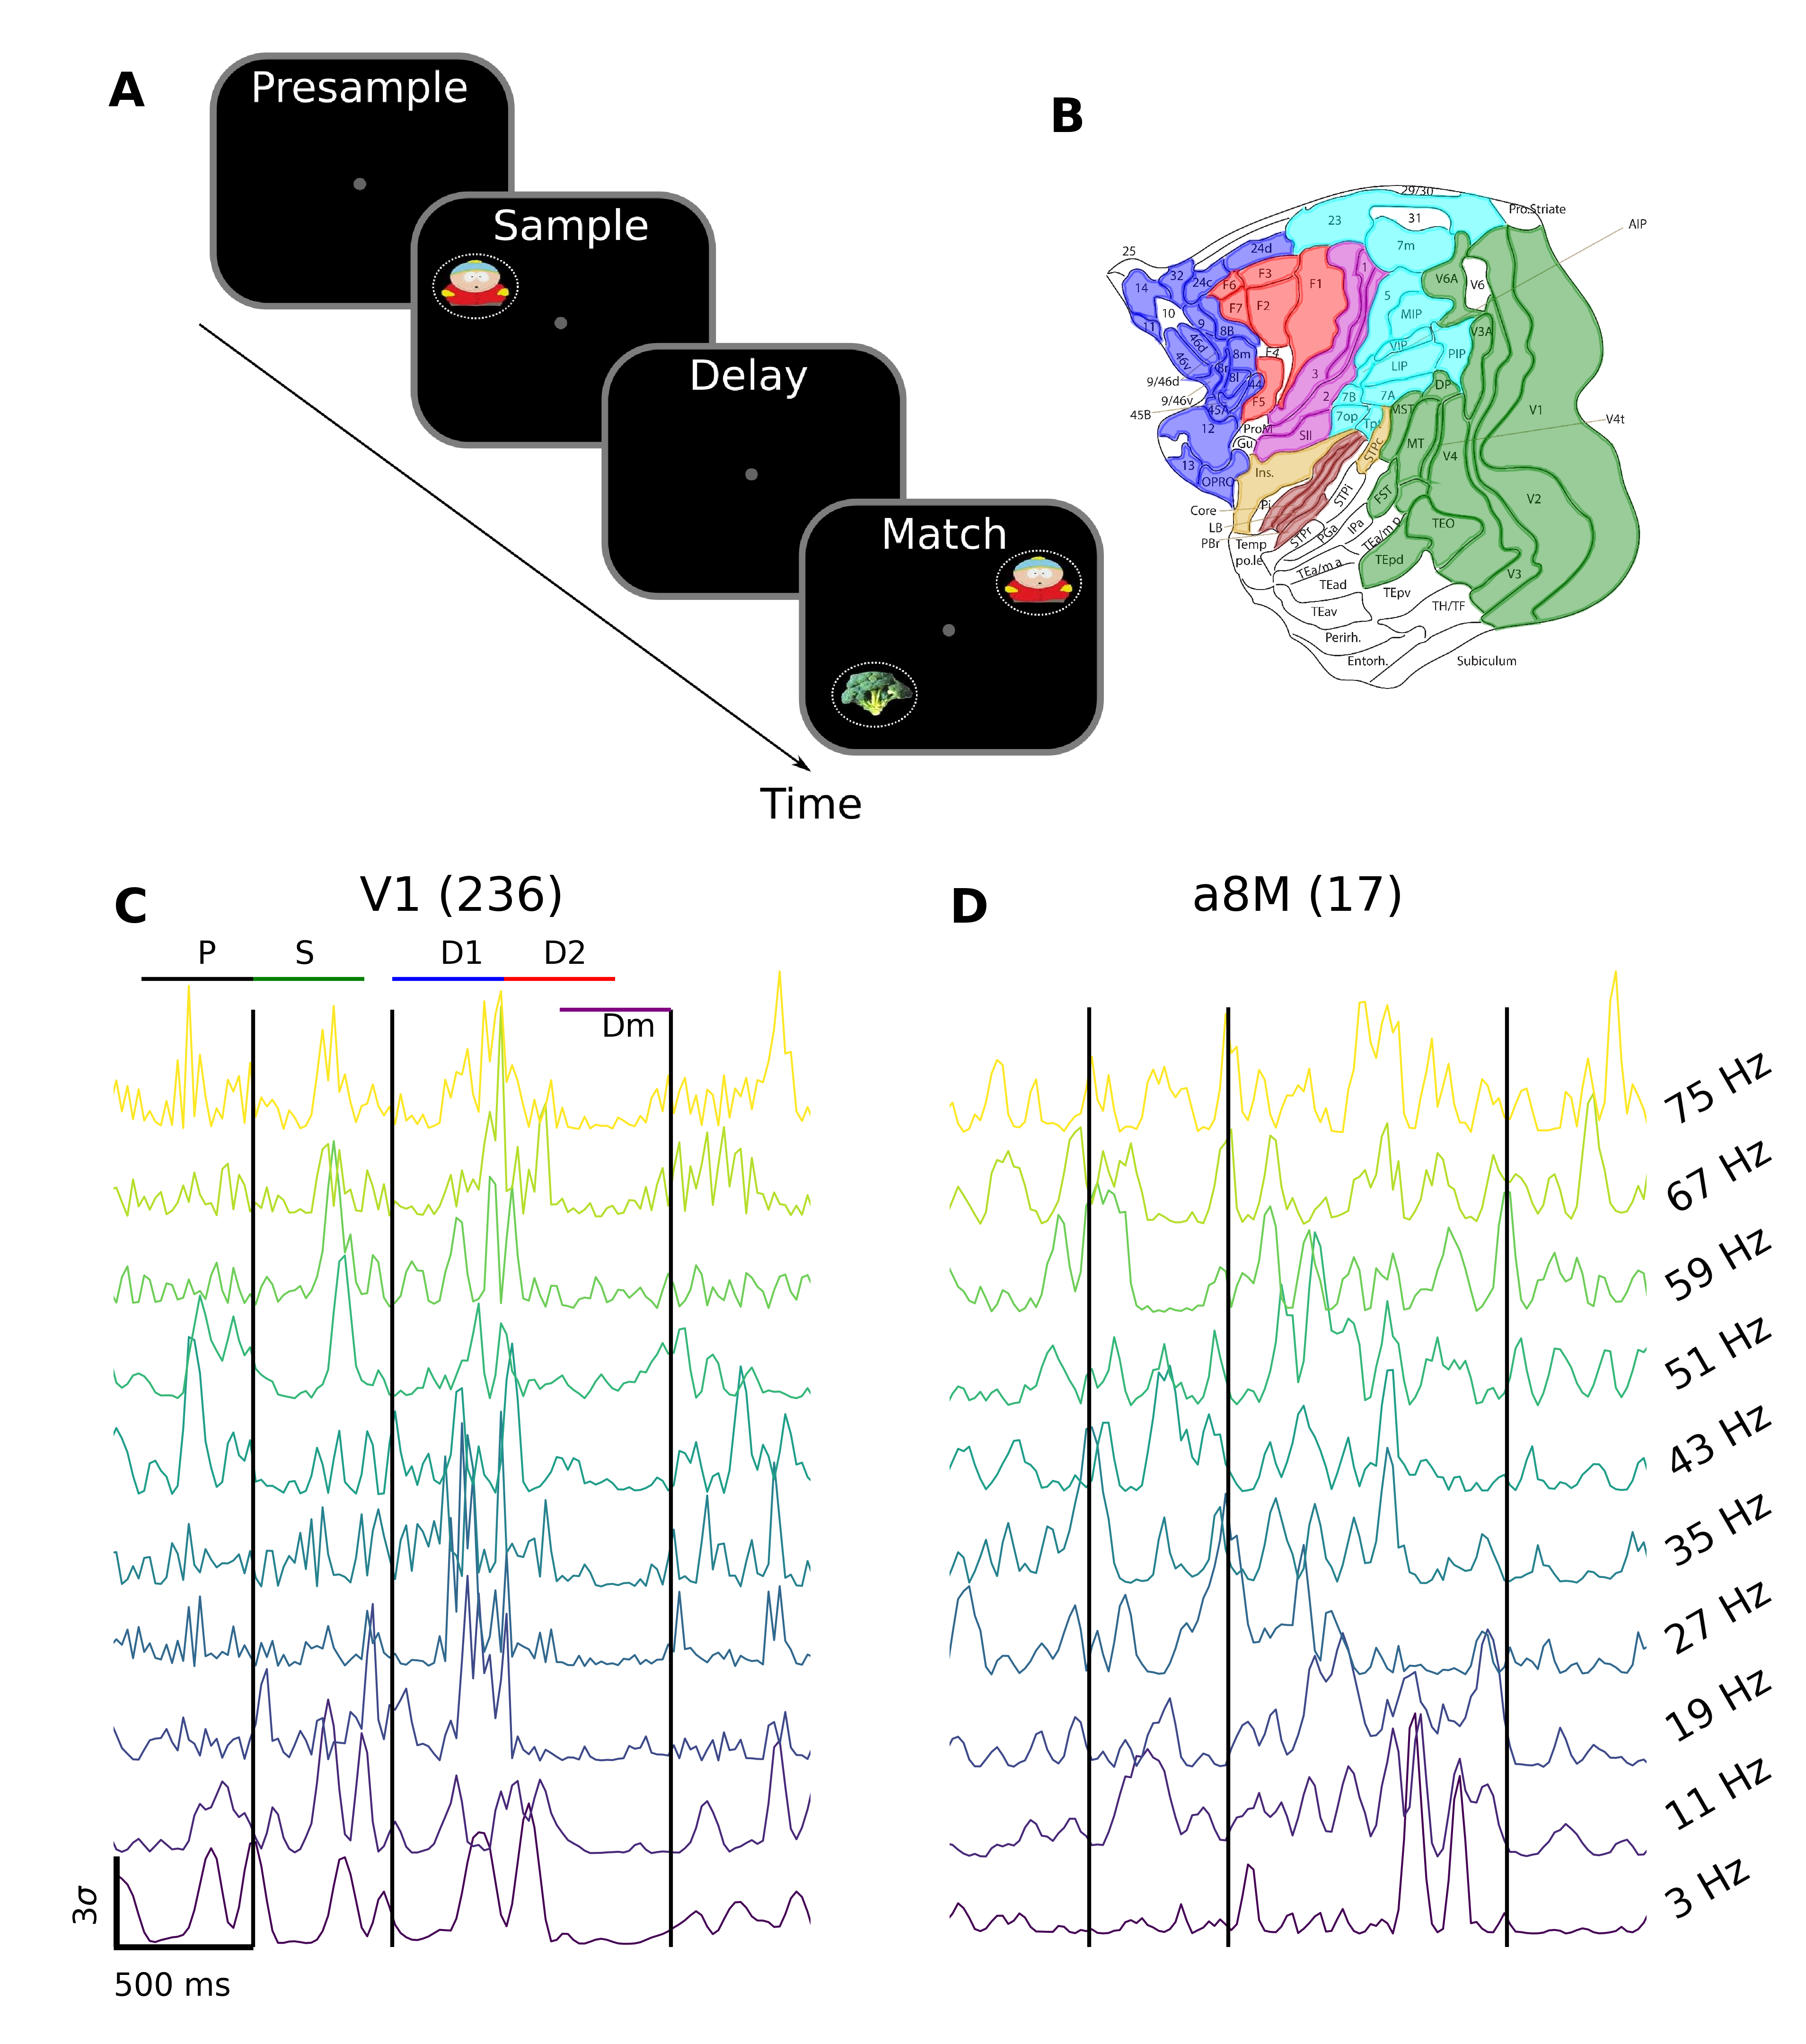

In [15]:
fig = plt.figure(figsize=(6, 7), dpi=600)

gs0 = fig.add_gridspec(
    nrows=1,
    ncols=2,
    left=0.1,
    right=0.95,
    wspace=0,
    bottom=0.60,
    top=0.99,
    width_ratios=[1, 0.6],
)
gs1 = fig.add_gridspec(
    nrows=1,
    ncols=2,
    left=0.05,
    right=0.95,
    hspace=0.4,
    bottom=0.01,
    top=0.55,
)

ax0 = plt.subplot(gs0[0])
plot_circles(ax0)
ax1 = plt.subplot(gs0[1])
plot_brain_areas(ax1)

#######################
ax2 = plt.subplot(gs1[0])
plot_ts_power(ax2, "V1 (236)", showscale=True, showepochs=True)
plt.title("V1 (236)", pad=3)
plt.axis("off")

#######################
ax3 = plt.subplot(gs1[1])
plot_ts_power(ax3, "a8M (17)", showfreqs=True)
plt.title("a8M (17)", pad=3)
plt.axis("off")

plot.add_panel_letters(
    fig,
    axes=[ax0, ax1, ax2, ax3],
    fontsize=12,
    xpos=[
        -0.1,
        -0.1,
        -0.0,
        -0.0,
    ],
    ypos=[0.93, 1.1, 1.0, 1.0],
)

bg = plot.Background(visible=False)
plt.savefig("figures/n1/figure1.pdf", bbox_inches="tight")